# Finding Lane Lines on the Road

In [11]:
import os.path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats

%matplotlib inline

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let me check what images I am going to work with

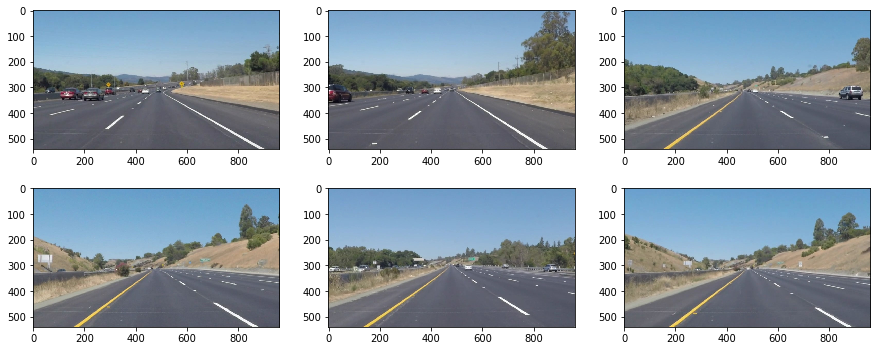

In [13]:
IMAGE_FOLDER="test_images"
images = []

for image in os.scandir(IMAGE_FOLDER):
    images.append(mpimg.imread(image.path))
    
if images:
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = images[0].shape
    
# just a helper function to display a list of images
def show_images(images_to_show, row=2, col=3, fig_size=(15, 6)):
    f, axes = plt.subplots(2, 3)
    f.set_size_inches(fig_size)
    for y in range(0, row):
        for x in range(0, col):
            ax = axes[y, x]
            ax.imshow(images_to_show[y * col + x], cmap='gray')
            
show_images(images)

Just for convenience I keep all the configurations in one place. It helps not to bother the structure of the algorithm.

In [14]:
class ImageConfig(object):
    def __init__(self, width=960, height=540):
        self.width = width
        self.height = height
    
class ColorConfig(object):
    yellow_lower = np.array([20, 20, 110])
    yellow_upper = np.array([45, 255, 255])
    white_sensitivity = 35
    white_lower = np.array([0, 0, 225 - white_sensitivity])
    white_upper = np.array([255, white_sensitivity, 255])
    
class ROI(object):
    def __init__(self, img_config, horizontal_step = 100, vertical_step = 50, bottom=0):
        self.vertices = np.array([
        [0, img_config.height - bottom],
        [img_config.width, img_config.height - bottom],
        [img_config.width/2 + horizontal_step, img_config.height/2 + vertical_step],
        [img_config.width/2 - horizontal_step, img_config.height/2 + vertical_step],], dtype='int32')

class GaussianConfig(object):
    kernel = (3, 9)
    
class DilateConfig(object):
    kernel = np.ones((3, 5),np.uint8)

class CannyConfig(object):
    low = 30
    high = 60

class HoughConfig(object):
    rho = 1
    theta = np.pi/180
    threshold = 40
    min_line_len = 5
    max_line_gap = 3
    
class LineConfig(object):
    def __init__(self, y_bottom=540, y_top=350):
        self.mean_slope = 0.59
        self.std_slope = 0.04
        self.y_bottom = y_bottom
        self.y_top = y_top

In [15]:
class Config(object):
    def __init__(self):
        self.image = ImageConfig()
        self.smooth = GaussianConfig()
        self.dilate = DilateConfig()
        self.color = ColorConfig()
        self.roi = ROI(self.image) 
        self.canny = CannyConfig()
        self.hough = HoughConfig()
        self.line = LineConfig()
        
class ChallengeConfig(object):
    def __init__(self):
        self.image = ImageConfig(width=1280, height=720)
        self.smooth = GaussianConfig()
        self.dilate = DilateConfig()
        self.color = ColorConfig()
        self.roi = ROI(self.image, bottom=45)
        self.canny = CannyConfig()
        self.hough = HoughConfig()
        self.line = LineConfig(y_bottom=690, y_top=460)

In [16]:
class LaneLinesDetector(object):
    def __init__(self, config, memory_size=1, annotations=False):
        self.config = config
        # define how many frames use for averaging
        self.memory = []
        self.max_memory_size = memory_size
        # define if to add annotations to the image
        self.annotations = annotations
        
#==================== THE PIPELINE METHOD ====================#
    def detect(self, image):
        # 1. Color based segmentation
        color_segm_img = self.step_color_segm(image)
        # 2. Detect edges
        canny_edge_img = self.step_canny_edge(image)
        # 3. Combine step 1 and 2
        combined_img = cv2.bitwise_and(color_segm_img, canny_edge_img)
        # 4. Detect hough lines
        hough_lines = self.step_detect_lines(combined_img)
        if hough_lines is None:
            return image
        # 5. Sort lines depending on the sign of the slope 
        n_slope, p_slope = self.step_sort_lines(self.memory)
        # 6. Approximate and display lines
        line_img = self.step_approx_lines(image, n_slope, p_slope)
        weighted_img = cv2.addWeighted(image, 0.8, line_img, 1.0, 0.0)
        # 7. Add annotation if needed
        if self.annotations:
            # create hough annotation
            hough_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
            for hough_lines in self.memory:
                for line in hough_lines:
                    for x1, y1, x2, y2 in line:
                        cv2.line(hough_image, (x1, y1), (x2, y2), 255, 15)
            # create roi annotation
            cropped_roi_img = self.crop_to_roi(image, [self.config.roi.vertices])
            
            images = [
                cropped_roi_img, color_segm_img, canny_edge_img, combined_img, hough_image]
            labels = [
                'region of interest', 'color segmentation', 'canny', 'canny + color segm.', 'hough']
            weighted_img = self.add_annotations(weighted_img, images, labels)
            
        return weighted_img
#==================== END ====================#
        
    def reset_memory(self):
        self.memory = []
        
    def step_color_segm(self, image):
        smoothed_img = cv2.GaussianBlur(image, self.config.smooth.kernel, 0)
        filtered_img = self.color_filter(smoothed_img, self.config.color, self.config.dilate)
        # crop to roi
        return self.crop_to_roi(filtered_img, [self.config.roi.vertices])
    
    def step_canny_edge(self, image):
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_smoothed_img = cv2.GaussianBlur(gray_img, self.config.smooth.kernel, 0)
        canny_img = cv2.Canny(gray_smoothed_img, self.config.canny.low, self.config.canny.high)
        return canny_img
    
    def step_detect_lines(self, image):
        # detect hough lines
        hough_lines = cv2.HoughLinesP(
            image,
            self.config.hough.rho, 
            self.config.hough.theta,
            self.config.hough.threshold,
            np.array([]),
            minLineLength=self.config.hough.min_line_len,
            maxLineGap=self.config.hough.max_line_gap
        )
        
        # update the memory
        if hough_lines is not None:
            if len(self.memory) == self.max_memory_size:
                self.memory = self.memory[1:]
            self.memory.append(hough_lines)
            
        # if not enough data in the memory
        if len(self.memory) < self.max_memory_size:
            return None
        
        return hough_lines
    
    def step_sort_lines(self, lines):
        positive_slopes = []
        negative_slopes = []
        mean = self.config.line.mean_slope
        std = self.config.line.std_slope
        
        for hough_lines in lines:
            for line in hough_lines:
                for x1, y1, x2, y2 in line:
                    a = (y2 - y1) / (x2 - x1)
                    abs_degree = abs(np.arctan(a))
                if not(mean - 3 * std <= abs_degree <= mean + 3 * std):
                    continue
                elif a > 0:
                    positive_slopes.append((x1, y1))
                    positive_slopes.append((x2, y2))
                elif a < 0:
                    negative_slopes.append((x1, y1))
                    negative_slopes.append((x2, y2))
        return negative_slopes, positive_slopes
        
    def step_approx_lines(self, image, n_slope, p_slope):
        line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        for slopes in [n_slope, p_slope]:
            slopes = sorted(slopes, key=lambda tup: tup[0])
            x = np.asarray([v[0] for v in slopes])
            y = np.asarray([v[1] for v in slopes])
            
            y_bottom = self.config.line.y_bottom
            y_top = self.config.line.y_top
            
            # this could be lineregres from scipy.stats, but this is 
            # way more handy to use
            coef = np.polyfit(y, x, 1)
            p = np.poly1d(coef)
            new_y = np.linspace(y_bottom, y_top, 100)
            new_x = p(new_y)
            
            for i in range(100):
                cv2.line(
                    line_img,
                    (int(new_x[i-1]), int(new_y[i-1])),
                    (int(new_x[i]), int(new_y[i])), [0, 255, 0], 15)
        return line_img
    
    def add_annotations(self, image, images, labels):
        draw_image = image.copy()
        ratio = 0.18
        resized = cv2.resize(image, (0, 0), fx=ratio, fy=ratio)
        r_h, r_w, _ = resized.shape
        init_h, init_w = 10, 40
        space = 10
        
        for i, image in enumerate(images):
            resized = cv2.resize(image, (0, 0), fx=ratio, fy=ratio)
            if len(resized.shape) == 2:
                resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
            draw_image[
                (init_h):(init_h + r_h),
                (init_w + i * (r_w + space)) : (init_w + (i + 1) * r_w + i * space),:] = resized
            cv2.putText(
                draw_image,
                labels[i],
                (init_w + i * (r_w + space) + 5, init_h + 15),
                cv2.FONT_HERSHEY_DUPLEX, 0.4, (0, 255, 0))
        return draw_image
        
    
    def color_filter(self, image, color_config, dil_config):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        yellow_range = cv2.inRange(hsv, color_config.yellow_lower, color_config.yellow_upper)
        white_range = cv2.inRange(hsv, color_config.white_lower, color_config.white_upper)
        merged = yellow_range + white_range
        _, thresh = cv2.threshold(merged, 100, 255, cv2.THRESH_BINARY)
        return cv2.dilate(thresh, dil_config.kernel, iterations=1)
    
    def crop_to_roi(self, img, vertices):
        mask = np.zeros_like(img)
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

In [17]:
detector = LaneLinesDetector(Config())
video_detector = LaneLinesDetector(Config(), annotations=True, memory_size=3)
challenge_detector = LaneLinesDetector(ChallengeConfig(), annotations=True, memory_size=7)

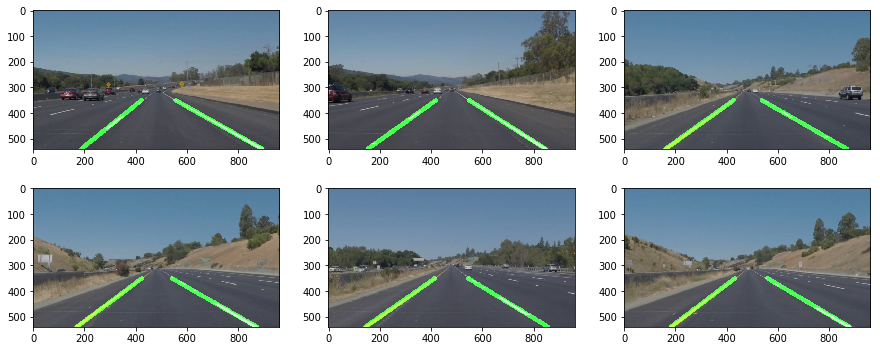

In [18]:
lines_detected = []
for i, image in enumerate(images):
    img_lines = detector.detect(image)
    img_bgr = cv2.cvtColor(img_lines, cv2.COLOR_RGB2BGR)
    cv2.imwrite("test_images_output/{}.jpg".format(i), img_bgr)
    lines_detected.append(img_lines)
    
show_images(lines_detected)

In [19]:
def process_video(input, output):
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(video_detector.detect) 
    %time white_clip.write_videofile(output, audio=False)
    
def process_challenge(input, output):
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(challenge_detector.detect) 
    %time white_clip.write_videofile(output, audio=False)

challenge_detector.reset_memory()
process_challenge('test_videos/challenge.mp4', 'test_videos_output/challenge.mp4')

video_detector.reset_memory()
process_video('test_videos/solidYellowLeft.mp4', 'test_videos_output/solidYellowLeft.mp4')

video_detector.reset_memory()
process_video('test_videos/solidWhiteRight.mp4', 'test_videos_output/solidWhiteRight.mp4')

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 26.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.1 s, sys: 1.19 s, total: 11.3 s
Wall time: 9.98 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:13<00:00, 50.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15 s, sys: 1.1 s, total: 16.1 s
Wall time: 13.8 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 47.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.13 s, sys: 468 ms, total: 5.6 s
Wall time: 5.05 s
